# Project Part 2

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/entrylevelcs/CS39AA-Project/blob/main/project_part2.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/entrylevelcs/CS39AA-Project/blob/main/project_part2.ipynb)


## 1. Introduction/Background

For this part of the project we are taking the nearest neighbors model and training it using both our AI and real data sets. From this simple model we can see how well each of the different training data sets do after being optimizing the hyperparameters of this simple model.

## 2. Simple Modeling with KNeighborsClassifier

In [1]:
# import all of the python modules/packages you'll need here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
# ...

Get the data set from real steam reviews. The specific set of data that I am using for this notebook comes from https://www.kaggle.com/datasets/andrewmvd/steam-reviews/ but is just a sample of 25000 from the entire set.

In [2]:
human_data = 'https://raw.githubusercontent.com/entrylevelcs/CS39AA-Project/main/human_dataset.csv'
df = pd.read_csv(human_data)
df = df[df["review_text"].notnull()]
sample_size = len(df)
#sample_size = 25000
#df = df.sample(sample_size)
# previous two lines are for sampling from the entire human dataset

Get the data set that was generated by chatgpt. This review data started as only being about CS:GO but has been expanded to be more general and talk about other games.

In [3]:
ai_data = 'https://raw.githubusercontent.com/entrylevelcs/CS39AA-Project/main/gpt3.5_generated_data.csv'
df2 = pd.read_csv(ai_data)

Sets up our different inputs and outputs. X and y are the inputs and outputs from the real steam reviews while X1 and y1 are from the AI generated reviews. I also adjusted the test size so that the training data size the same length as the AI generated data set. From the shape of each we can see that the vocab size is 11127 words.

In [4]:
X = df['review_text'].copy()
y = df['review_score'].copy()
X1 = df2['Review'].copy()
y1 = df2[' Sentiment'].copy()
ai_data_size = X1.size

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=((sample_size-ai_data_size)/sample_size), random_state=21)

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train_raw.values.astype('U')).toarray()
X_val = tfidf_vectorizer.transform(X_val_raw.values.astype('U')).toarray()
X1_train = tfidf_vectorizer.transform(X1.values.astype('U')).toarray()

Creates a quick model using KNeighborsClassifier and the real reviews so that we can see how a model trained with the real reviews performs. The accuracy printed from this block of code represents the testing accuracy. Note that the optimal n_neighbors value is already being used.

accuracy (on y_train): 0.9627


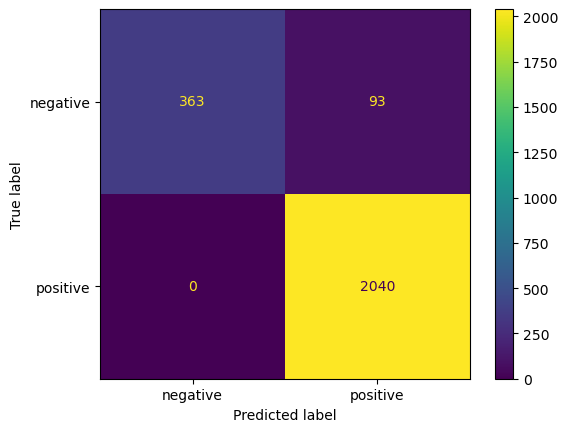

In [5]:
model = KNeighborsClassifier(n_neighbors=16,weights='distance')
# n_neighbors value was determined with the validation and testing loss plots farther down in this notebook
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)

disp = ConfusionMatrixDisplay(confusion_matrix(y_train, predictions_train), display_labels=['negative', 'positive'])
disp.plot()
print(f"accuracy (on y_train): {accuracy_score(y_train, predictions_train):.4f}")

Continuation of the previous code but we are testing the model with the validation data set. The accuracy printed from this block of code represents the validation accuracy.

accuracy (on y_val): 0.8198


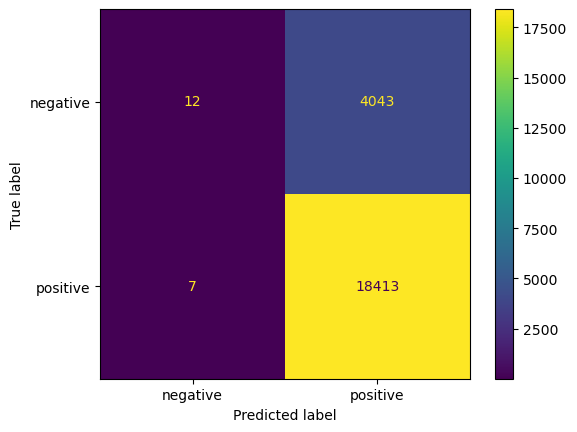

In [6]:
predictions_val = model.predict(X_val)
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions_val), display_labels=['negative', 'positive'])
disp.plot()
print(f"accuracy (on y_val): {accuracy_score(y_val, predictions_val):.4f}")

We run a quick sweep of some n_neighbor values in order to find one that will "optimize" our current model.

c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: element

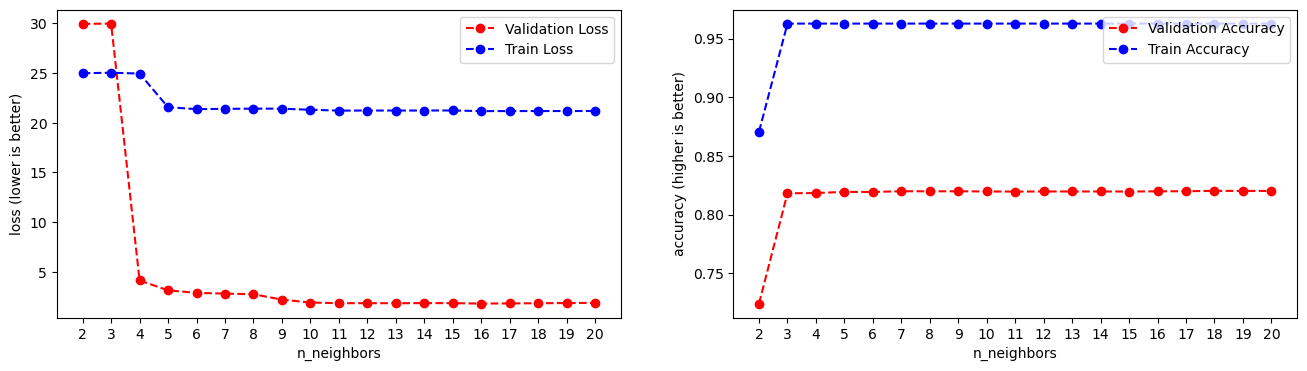

In [7]:
# A function to create and fit a RF with a specific number of trees
def tuneModel(hyperparam_value):
    rf_model = KNeighborsClassifier(n_neighbors=hyperparam_value,weights='distance', n_jobs=-1)
    #rf_model = RandomForestClassifier(min_samples_split=hyperparam_value, random_state=1)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_val)
    y_val_pred = rf_model.predict(X_val)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=['negative', 'positive'])
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=['negative', 'positive'])
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

hyp_param_vals = list(range(2,21,1))
metrics = []
for hp in hyp_param_vals:
    metrics.append(tuneModel(hp))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.set_xticks(hyp_param_vals)
ax1.set(xlabel="n_neighbors", ylabel="loss (lower is better)")
ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
ax1.legend(["Validation Loss", "Train Loss"], loc=1)

ax2.set_xticks(hyp_param_vals)
ax2.set(xlabel="n_neighbors", ylabel="accuracy (higher is better)")
ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=1)

We select a n_neighbor value that gives a high test_acc value and low test_loss value. Running the notebook we can see that an n_neighbors value of 16 gives a good compromise between a high accuracy and a low loss.

In [8]:
tuning_results = np.array([hyp_param_vals, [round(metric[1],2) for metric in metrics], [round(metric[3],2) for metric in metrics]])
df_tuning_results = pd.DataFrame({'hyperparam':hyp_param_vals, 'test_loss':[metric[1] for metric in metrics], 'test_acc':[metric[3] for metric in metrics]})
print(df_tuning_results)

    hyperparam  test_loss  test_acc
0            2  29.928170  0.724138
1            3  29.957749  0.818109
2            4   4.143595  0.818331
3            5   3.153875  0.819310
4            6   2.898450  0.819266
5            7   2.821561  0.819889
6            8   2.760440  0.819800
7            9   2.220578  0.819844
8           10   1.925088  0.819666
9           11   1.860959  0.819577
10          12   1.861787  0.819666
11          13   1.856655  0.819666
12          14   1.866542  0.819666
13          15   1.864874  0.819622
14          16   1.820504  0.819800
15          17   1.839008  0.819889
16          18   1.852170  0.820200
17          19   1.873720  0.820156
18          20   1.895952  0.820111


Now we do the same thing but with the AI generated data set. The accuracy printed from this code block represents the training accuracy of the AI generated data set. Note that the optimal n_neighbors value is already being used.

accuracy (on y_val): 0.9984


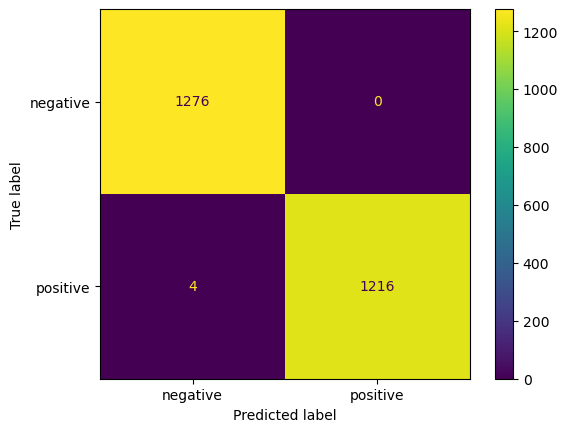

In [9]:
model = KNeighborsClassifier(n_neighbors=16,weights='distance')
model = model.fit(X1_train, y1)

predictions_val = model.predict(X1_train)
disp = ConfusionMatrixDisplay(confusion_matrix(y1, predictions_val), display_labels=['negative', 'positive'])
disp.plot()
print(f"accuracy (on y_val): {accuracy_score(y1, predictions_val):.4f}")

Continuation of the previous code but we are testing the model with the validation data set. The accuracy printed from this block of code represents the validation accuracy.

accuracy (on y_val): 0.5512


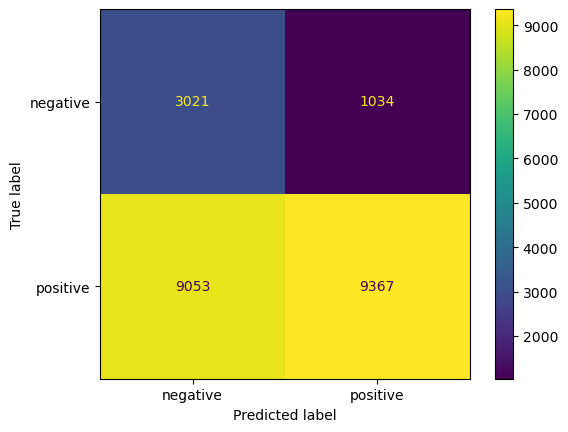

In [10]:
model = model.fit(X1_train, y1)

predictions_val = model.predict(X_val)
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions_val), display_labels=['negative', 'positive'])
disp.plot()
print(f"accuracy (on y_val): {accuracy_score(y_val, predictions_val):.4f}")

We run a quick sweep of some n_neighbor values in order to find one that will "optimize" this AI trained model.

c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
c:\Users\Muajeh Lee\anaconda3\Lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: element

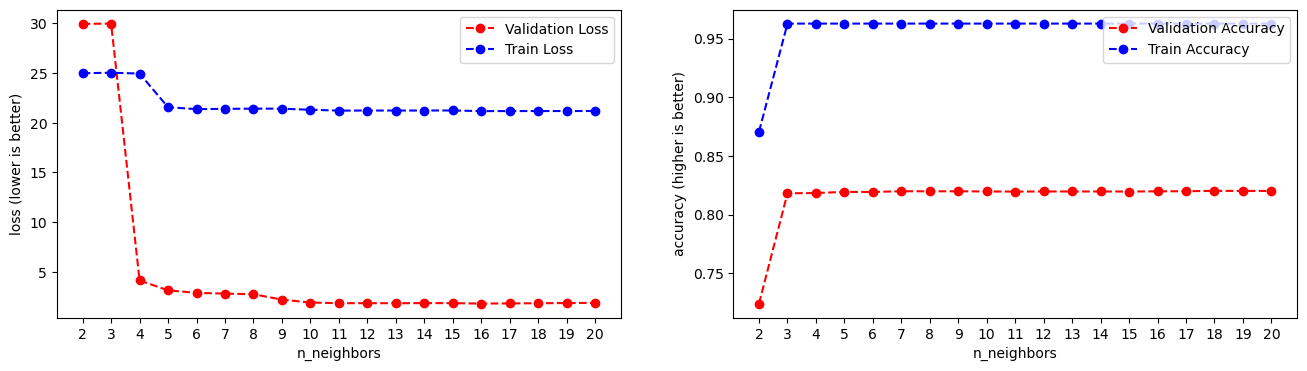

In [11]:
# A function to create and fit a RF with a specific number of trees
def tuneModel(hyperparam_value):
    rf_model = KNeighborsClassifier(n_neighbors=hyperparam_value,weights='distance', n_jobs=-1)
    #rf_model = RandomForestClassifier(min_samples_split=hyperparam_value, random_state=1)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_val)
    y_val_pred = rf_model.predict(X_val)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=['negative', 'positive'])
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=['negative', 'positive'])
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

hyp_param_vals = list(range(2,21,1))
metrics = []
for hp in hyp_param_vals:
    metrics.append(tuneModel(hp))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.set_xticks(hyp_param_vals)
ax1.set(xlabel="n_neighbors", ylabel="loss (lower is better)")
ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
ax1.legend(["Validation Loss", "Train Loss"], loc=1)

ax2.set_xticks(hyp_param_vals)
ax2.set(xlabel="n_neighbors", ylabel="accuracy (higher is better)")
ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=1)

We select a n_neighbor value that gives a high test_acc value and low test_loss value. Running the notebook we can see that an n_neighbors value of 16 gives a good compromise between a high accuracy and a low loss. This turns out to be the same n_neighbors value that the real reviews data set had.

In [12]:
tuning_results = np.array([hyp_param_vals, [round(metric[1],2) for metric in metrics], [round(metric[3],2) for metric in metrics]])
df_tuning_results = pd.DataFrame({'hyperparam':hyp_param_vals, 'test_loss':[metric[1] for metric in metrics], 'test_acc':[metric[3] for metric in metrics]})
print(df_tuning_results)

    hyperparam  test_loss  test_acc
0            2  29.928170  0.724138
1            3  29.957749  0.818109
2            4   4.143595  0.818331
3            5   3.153875  0.819310
4            6   2.898450  0.819266
5            7   2.821561  0.819889
6            8   2.760440  0.819800
7            9   2.220578  0.819844
8           10   1.925088  0.819666
9           11   1.860959  0.819577
10          12   1.861787  0.819666
11          13   1.856655  0.819666
12          14   1.866542  0.819666
13          15   1.864874  0.819622
14          16   1.820504  0.819800
15          17   1.839008  0.819889
16          18   1.852170  0.820200
17          19   1.873720  0.820156
18          20   1.895952  0.820111
